<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Text Term Frequency Analysis (SQL)
  <br>
       <img id="teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>

<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Introduction</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
This demo will analyze the text in rows of the table to find the TF-IDF or Term Frequency-Inverse Document Frequency is an indicator of a term's importance in a specific document based on the entire corpus of documents. This is a demonstration of Vantage capabilities for functional demos e.g.
    <li style = 'font-size:16px;font-family:Arial;color:#00233C'> NGramSplitter Function - tokenizes (splits) an input stream of text and outputs n multigrams (called n-grams) based on the specified Reset, Punctuation, and Delimiter syntax elements.</li>
</p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'> This notebook demonstrate how the function is used in SQL kernel, there is a similar notebook which shows the same features in Python kernel. </p>

<p style = 'font-size:18px;font-family:Arial;color:#00233C'><b>Steps</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li style = 'font-size:16px;font-family:Arial;color:#00233C'> Connect to Vantage and read the dataset. </li>
    <li style = 'font-size:16px;font-family:Arial;color:#00233C'> Use NGramSplitter SQL to create a table of grams of n-size. </li>
    <li style = 'font-size:16px;font-family:Arial;color:#00233C'> Express SQL to calculate TF-IDF and store the output in a table. </li>
    <li style = 'font-size:16px;font-family:Arial;color:#00233C'> Basic visualization to show top 30 important terms. </li>
</p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>1. Connect to Vantage </b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>You will be prompted to provide the password. Enter your password, press Enter, then use down arrow to go to next cell.</p>

In [1]:
%connect local, hidewarnings=true

Password: ········


Success: 'local' connection established and activated for user 'demo_user', with default database 'demo_user'


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Setup for execution of notebook. Begin running steps with Shift + Enter keys.</p>

In [2]:
SET query_band='DEMO=Text_Term_Frequency_SQL.ipynb;' UPDATE FOR SESSION;

Success: 1 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>Getting Data for This Demo</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We have provided data for this demo on cloud storage. In this demo since we are using Temporal table we will be creating databases and tables in local storage and use them in the notebook. Please execute the procedure in the next cell.</p>


In [3]:
CALL get_data('DEMO_Retail_cloud');    -- takes about 25 seconds, estimated space: 0 MB
--CALL get_data('DEMO_Retail_local');     -- takes about 50 seconds, estimated space: 23 MB

Success: 0 rows affected

Success: 0 rows affected

,Message
1,That ran for 0:00:32.64 with 11 statements and 0 errors.


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Optional step – if you want to see status of databases/tables created and space used.</p>


In [4]:
CALL space_report();  -- optional, takes about 10 seconds

Success: 0 rows affected

Success: 0 rows affected

,Space_Report
1,"You have: #databases=1 #tables=1 #views=22 You have used 1.1 MB of 30,678.9 MB available - 0.0% ... Space Usage OK"
2,
3,Database Name #tables #views Avail MB Used MB
4,"demo_user 1 18 30,678.9 MB 1.1 MB"
5,DEMO_Retail 0 4 0.0 MB 0.0 MB


<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b> Access data in Vantage  </b> </p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Let us check the data sample</p>

In [5]:
SELECT TOP 5 * FROM DEMO_Retail.Web_Comment;

,comment_id,customer_id,comment_text,comment_summary
1,12072,1033,,
2,734,1110,"The fabric and detailing of this dress is of superior quality, but unfortunately it runs huge-- you definitely need to wear a tank or cami underneath. i am 5'9 145lbs with massive shoulders/smaller bust and i got the xs petite!",Amazingly cute but runs huge!
3,17496,1083,"This dress, like all byron lars dresses is a work of art. it has true quality of workmanship. and fits like a glove. i always get compliments when i wear any of his dresses and i have 5!. this one is somewhere between casual and dressy. perfect for a dinner out on a saturday night!. order a petite if you are under 5 5""",Love byron lars
4,9992,1110,"So cute! i get tons of compliments whenever i wear it. very comfortable. i ordered a petite l and it's a little big. i usually buy the petite m, but due to the under slip i wasn't sure.",
5,7443,941,"I ordered my usual sz s during the promo. arrived yesterday & the fit is perfect w/ a little room to spare for layering. it's a snap front closure, front patch pockets, & attached hood that is small to med size-not huge or overwhelming. it's 100% acrylic which isn't my 1st choice, but soft, comfy & seems good quality. length falls abt 3"" below my knees. arm length is fine. pretty much looks as in the pic including the marled color. if you are in need of a great functional long swtr w/ good looks",A great long swtr w/ patch pockets!


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>2. Use the NGram Splitter SQL Function</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>NGram function will split the corpus of documents into "terms" (grams) of selected size.  Specifically, this example will create a table called "tbl_grams" that is the result of splitting each "document" (review) into two-word chunks (grams).  Each row in this table includes;
<ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>The two-word chunk (ngram).</li>
    <li>The source review id (row_id).</li>
     <li>Chunk length (n).</li>
     <li>The count of this chunk in all the reviews (frequency).</li>
     <li>The count of all chunks in the review (totalcnt)</li>
</ol>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
The splitting algorithm can be controlled with delimeters, punctuation indicators, etc.</p>

In [6]:
%var ngram=2 

In [7]:
CREATE MULTISET TABLE tbl_grams AS (
    SELECT * FROM NGramSplitter ( 
        ON ( SELECT * FROM "DEMO_Retail"."Web_Comment" )   
        USING 
            TextColumn('comment_text') 
            Accumulate('comment_id') 
            Grams('${ngram}') 
            OverLapping('TRUE') 
            ConvertToLowerCase('TRUE') 
            Delimiter(' ') 
            Punctuation('[`~#^&*()-]') 
            OutputTotalGramCount('TRUE') 
            NGramColName('ngram') 
            GramLengthColName('n') 
            FrequencyColName('frequency') 
            TotalCountColName('totalcnt') 
    ) as ngram_out
    )
WITH DATA
PRIMARY INDEX (comment_id);

Success: 0 rows affected

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Let us see how the comment in the table looks like and how its ngram looks. We have taken one comment.</p>

In [8]:
SELECT * FROM DEMO_Retail.Web_Comment WHERE comment_id = 30;

,comment_id,customer_id,comment_text,comment_summary
1,30,1060,Beautifully made pants and on trend with the flared crop. so much cuter in person. love these!,


In [9]:
SELECT * FROM tbl_grams WHERE comment_id = 30;

,comment_id,ngram,n,frequency,totalcnt
1,30,beautifully made,2,1,14
2,30,flared crop,2,1,14
3,30,trend with,2,1,14
4,30,the flared,2,1,14
5,30,much cuter,2,1,14
6,30,made pants,2,1,14
7,30,love these,2,1,14
8,30,pants and,2,1,14
9,30,in person,2,1,14
10,30,with the,2,1,14


<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In the table created above we can see the NGram function applied to the web comment column. We can see the frequency and the total number of times the ngram appear in the column.</p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>3. Create the TF-IDF Table</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>TF-IDF</b> or <b>Term Frequency-Inverse Document Frequency</b> is an indicator of a term's <b>importance</b> in a specific document based on the entire corpus of documents.  This value is calculated by taking the Product of:
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Term Frequency = (Number of Terms in the Document)/(Number of Terms in the Corpus)</li>
    <li>Inverse Document Frequency = Natural Log((Total Number of Documents)/(Number of Documents with the Term))</li>
 </ul>   
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
This can be accomplished in SQL using the results table created using NGgram Splitter function in above step:</p>

In [10]:
CREATE MULTISET TABLE tbl_tf_idf AS (
    SELECT gr.comment_id AS comment_id,
        gr."ngram" AS term,
        CAST(CAST(gr.frequency AS FLOAT) / CAST(gr.totalcnt AS FLOAT) AS DECIMAL(10,6)) AS tf,
        CAST(LN(sel_docs.tot_docs / sel_docs.tot_term) AS DECIMAL(10,6)) AS idf,
        CAST(idf * tf AS DECIMAL(10,6)) AS tf_idf
    FROM tbl_grams AS gr
    -- get the number of docs where each term exists
    LEFT JOIN (
        SELECT "ngram", tot_term , tot_docs 
        FROM (
            (SELECT "ngram",COUNT(*) AS tot_term
            FROM tbl_grams
            GROUP BY "ngram") terms
            -- get the total doc count and join it to the table
            CROSS JOIN (SELECT COUNT(DISTINCT comment_id) AS tot_docs
            FROM tbl_grams ) AS sum_docs
        )
    ) sel_docs
    ON gr."ngram" = sel_docs."ngram"
    WHERE tf_idf > .5
)
WITH DATA
PRIMARY INDEX (comment_id);

Success: 0 rows affected

In [11]:
SELECT * FROM tbl_tf_idf WHERE comment_id = 30;

,comment_id,term,tf,idf,tf_idf
1,30,flared crop,.071429,10.027518,.716256
2,30,the flared,.071429,7.724888,.551781
3,30,trend with,.071429,9.334326,.666742
4,30,made pants,.071429,9.334326,.666742


<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>4. Visualize the Results</b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
Builtin Teradata Jupyter modules can provide simple visualizations of the data. Let us plot the top used 30 terms from our data.</p>

In [12]:
SELECT TOP 30 term, tf_idf
FROM tbl_tf_idf
ORDER BY tf_idf DESC;

,term,tf_idf
1,love embroidery,9.334326
2,great structure,9.334326
3,comfy cozy,8.418036
4,beautiful colors,6.470800
5,great style,6.470800
6,fits perfect,5.198497
7,fits perfect,5.198497
8,weird liner,5.013759
9,love birds,5.013759
10,great fit,4.934474


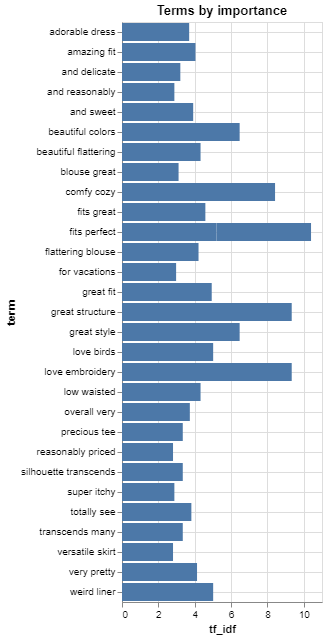

In [13]:
%chart x = tf_idf, y = term, title = "Terms by importance"

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>
In this plot we are plotting the top 30 terms which are used in the reviews. </p>

<hr style="height:2px;border:none;background-color:#00233C;">
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>5.  Cleanup </b>
<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>Worktables </b></p>

In [14]:
DROP TABLE tbl_grams;

Success: 19 rows affected

In [15]:
DROP TABLE tbl_tf_idf;

Success: 19 rows affected

<p style = 'font-size:18px;font-family:Arial;color:#00233C'> <b>Database and Tables </b></p>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The following code will clean up tables and databases created above.</p>

In [16]:
CALL remove_data('DEMO_Retail');-- takes about 5 seconds, optional if you want to use the data later

Success: 0 rows affected

Success: 0 rows affected

,Message
1,Removed objects related to DEMO_Retail. That ran for 0:00:09.62


<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Reference Links:</b></p>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
        <li>Teradata NGramSplitter Function Reference: <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Text-Analytic-Functions/NGramSplitter'>https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Text-Analytic-Functions/NGramSplitter</a></li>
  
</ul>



<footer style="padding-bottom:35px; background:#f9f9f9; border-bottom:3px solid #00233C">
    <div style="float:left;margin-top:14px">ClearScape Analytics™</div>
    <div style="float:right;">
        <div style="float:left; margin-top:14px">
            Copyright © Teradata Corporation - 2023,2024. All Rights Reserved
        </div>
    </div>
</footer>